In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
url = cdc_diabetes_health_indicators['metadata']['data_url']
print(url)

df = pd.read_csv(url)

# Separate the classes 
class_0 = df[df['Diabetes_binary'] == 0]
class_1 = df[df['Diabetes_binary'] == 1]

n_samples_per_class = 5000 // 2 #i want 2.5k samples of each one

# Randomly sample from each class
sampled_class_0 = class_0.sample(n=n_samples_per_class, random_state=42)
sampled_class_1 = class_1.sample(n=n_samples_per_class, random_state=42)

# Combine the samples
sampled_df = pd.concat([sampled_class_0, sampled_class_1])
df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df

https://archive.ics.uci.edu/static/public/891/data.csv


ID  Diabetes_binary  HighBP  HighChol  CholCheck  BMI  Smoker  \
0     199346                0       1         1          0   32       1   
1      28980                1       0         1          1   30       0   
2      31056                1       0         0          1   30       1   
3      90212                0       1         1          1   33       0   
4     141466                0       0         0          1   27       1   
...      ...              ...     ...       ...        ...  ...     ...   
4995  123223                1       1         1          1   32       1   
4996   70134                0       0         0          1   20       0   
4997  173533                1       1         1          1   28       1   
4998  169867                1       0         1          1   33       0   
4999  212333                0       0         0          1   26       0   

      Stroke  HeartDiseaseorAttack  PhysActivity  ...  AnyHealthcare  \
0          0                     0             1  ...              1   
1          0                     0             0  ...              1   
2          0                     0             1  ...              1   
3          0                     1             1  ...              1   
4          0                     0             0  ...              1   
...      ...                   ...           ...  ...            ...   
4995       0                     0             1  ...              1   
4996       0                     0             0  ...              1   
4997       0                     0             1  ...              1   
4998       0                     0             1  ...              1   
4999       0                     0             1  ...              1   

      NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  \
0               0        5        10        10         1    1    8          4   
1               0        1         0         0         0    0   10          4   
2               0        3         0         0         0    0    7          5   
3               0        3         5         5         1    0   10          6   
4               0        2         0         7         0    1    6          4   
...           ...      ...       ...       ...       ...  ...  ...        ...   
4995            0        4         0        30         0    1   10          3   
4996            0        2         2         2         1    0    7          5   
4997            1        3         2         0         0    0   13          5   
4998            0        4         7        10         1    1    8          5   
4999            0        1         0         0         0    1    8          4   

      Income  
0          2  
1          3  
2          6  
3          8  
4          7  
...      ...  
4995       3  
4996       3  
4997       4  
4998       7  
4999       7  

[5000 rows x 23 columns]

# Data Preprocessing (2.1)

In [2]:
# Check for missing values
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])  

Series([], dtype: int64)


In [3]:
print(df['Diabetes_binary'].value_counts()) #making sure even distribution

0    2500
1    2500
Name: Diabetes_binary, dtype: int64


In [4]:
# Check data types and observing if I need to convert anything
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   ID                    5000 non-null   int64
 1   Diabetes_binary       5000 non-null   int64
 2   HighBP                5000 non-null   int64
 3   HighChol              5000 non-null   int64
 4   CholCheck             5000 non-null   int64
 5   BMI                   5000 non-null   int64
 6   Smoker                5000 non-null   int64
 7   Stroke                5000 non-null   int64
 8   HeartDiseaseorAttack  5000 non-null   int64
 9   PhysActivity          5000 non-null   int64
 10  Fruits                5000 non-null   int64
 11  Veggies               5000 non-null   int64
 12  HvyAlcoholConsump     5000 non-null   int64
 13  AnyHealthcare         5000 non-null   int64
 14  NoDocbcCost           5000 non-null   int64
 15  GenHlth               5000 non-null   int64
 16  MentHl

In [5]:
#understanding the description of the data
#observing IQR , mean , min, etc.
df.describe()

ID  Diabetes_binary       HighBP     HighChol    CholCheck  \
count    5000.000000       5000.00000  5000.000000  5000.000000  5000.000000   
mean   126168.031000          0.50000     0.557600     0.529400     0.977800   
std     73190.134424          0.50005     0.496721     0.499185     0.147348   
min        23.000000          0.00000     0.000000     0.000000     0.000000   
25%     62335.000000          0.00000     0.000000     0.000000     1.000000   
50%    124980.500000          0.50000     1.000000     1.000000     1.000000   
75%    190151.500000          1.00000     1.000000     1.000000     1.000000   
max    253603.000000          1.00000     1.000000     1.000000     1.000000   

              BMI       Smoker       Stroke  HeartDiseaseorAttack  \
count  5000.00000  5000.000000  5000.000000           5000.000000   
mean     29.94800     0.472400     0.061800              0.153000   
std       7.41406     0.499288     0.240816              0.360024   
min      14.00000     0.000000     0.000000              0.000000   
25%      25.00000     0.000000     0.000000              0.000000   
50%      29.00000     0.000000     0.000000              0.000000   
75%      33.00000     1.000000     0.000000              0.000000   
max      95.00000     1.000000     1.000000              1.000000   

       PhysActivity  ...  AnyHealthcare  NoDocbcCost      GenHlth  \
count   5000.000000  ...    5000.000000  5000.000000  5000.000000   
mean       0.707200  ...       0.953200     0.091000     2.833800   
std        0.455093  ...       0.211231     0.287638     1.111407   
min        0.000000  ...       0.000000     0.000000     1.000000   
25%        0.000000  ...       1.000000     0.000000     2.000000   
50%        1.000000  ...       1.000000     0.000000     3.000000   
75%        1.000000  ...       1.000000     0.000000     4.000000   
max        1.000000  ...       1.000000     1.000000     5.000000   

          MentHlth     PhysHlth     DiffWalk          Sex          Age  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      3.735400     5.846800     0.253400     0.454600     8.609800   
std       8.091334    10.123054     0.435001     0.497984     2.830538   
min       0.000000     0.000000     0.000000     0.000000     1.000000   
25%       0.000000     0.000000     0.000000     0.000000     7.000000   
50%       0.000000     0.000000     0.000000     0.000000     9.000000   
75%       2.000000     5.000000     1.000000     1.000000    11.000000   
max      30.000000    30.000000     1.000000     1.000000    13.000000   

         Education      Income  
count  5000.000000  5000.00000  
mean      4.923000     5.65920  
std       1.022976     2.17991  
min       1.000000     1.00000  
25%       4.000000     4.00000  
50%       5.000000     6.00000  
75%       6.000000     8.00000  
max       6.000000     8.00000  

[8 rows x 23 columns]

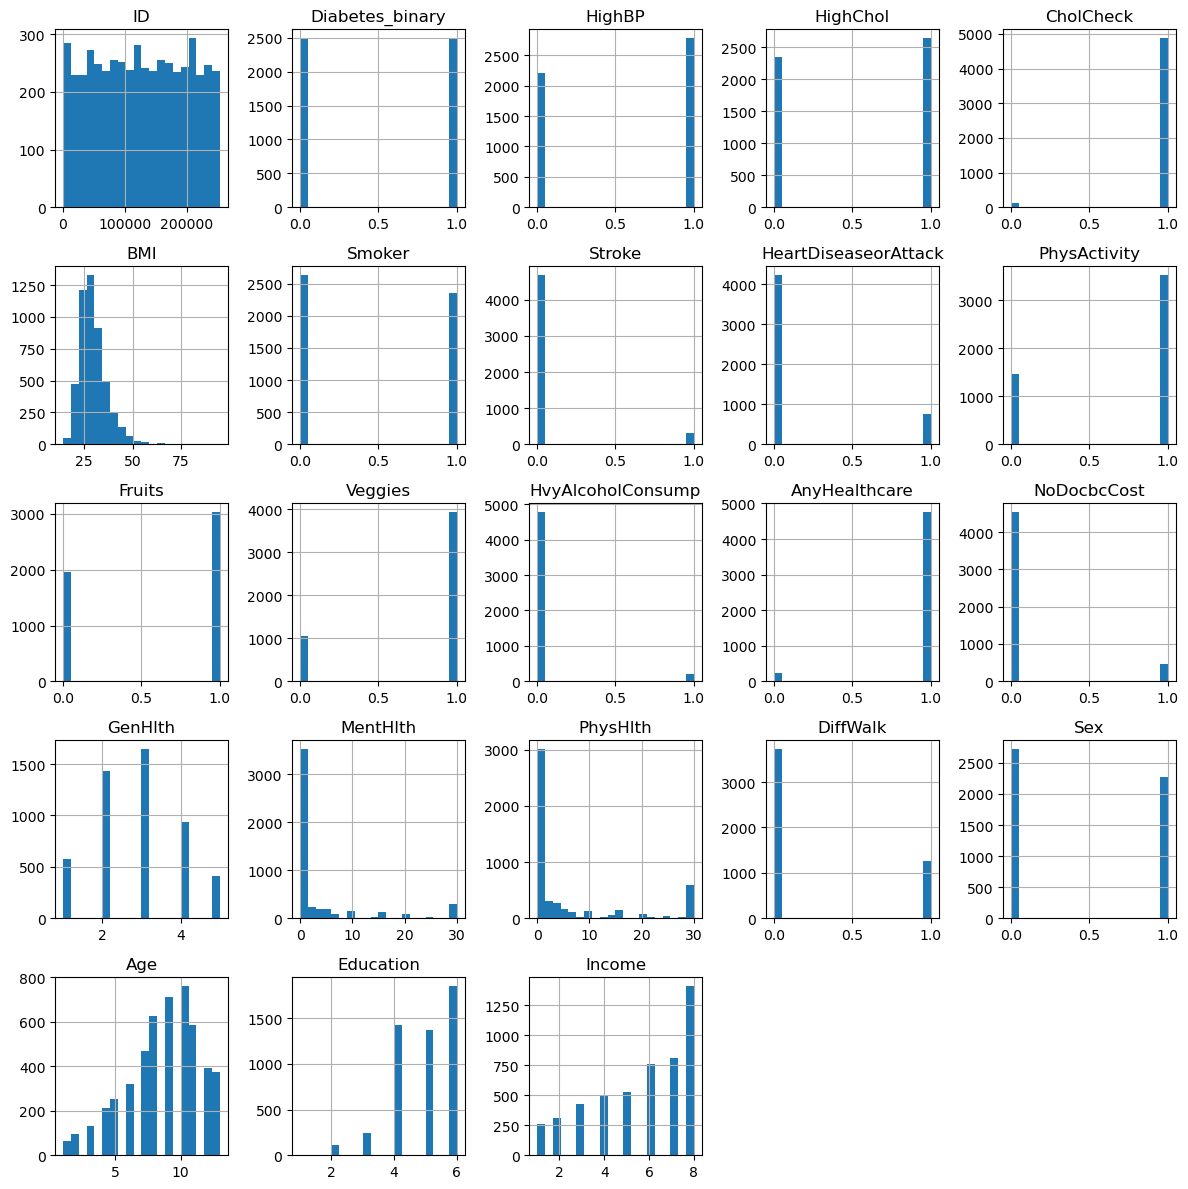

In [6]:
# Check if attributes are normally distributed by visualizing them
df.hist(figsize=(12, 12), bins=20)
plt.tight_layout()
plt.show()

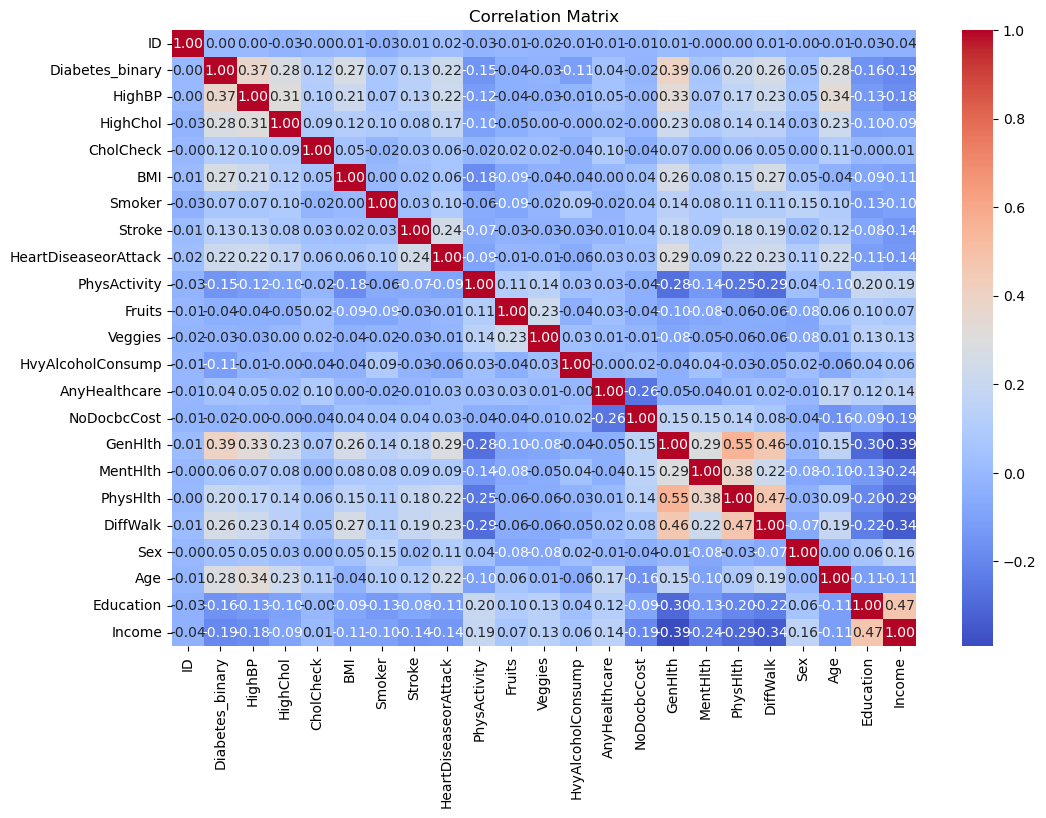

In [7]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [8]:
target_corr = correlation_matrix['Diabetes_binary'].sort_values(ascending=False)
f = target_corr[target_corr.abs() > 0.20].index #using .2 as my means of determining correlation
print(f)
features= ['GenHlth', 'HighBP', 'Age', 'HighChol', 'BMI', 
       'DiffWalk', 'PhysHlth', 'HeartDiseaseorAttack', 'Income'] #feature engineering

Index(['Diabetes_binary', 'GenHlth', 'HighBP', 'Age', 'HighChol', 'BMI',
       'DiffWalk', 'HeartDiseaseorAttack'],
      dtype='object')


# 2.2 Model Building/Tuning

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

# Split data into features and target 
X = df[features]
y = df['Diabetes_binary']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best parameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.70      0.71      0.71       476
           1       0.74      0.73      0.73       524

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



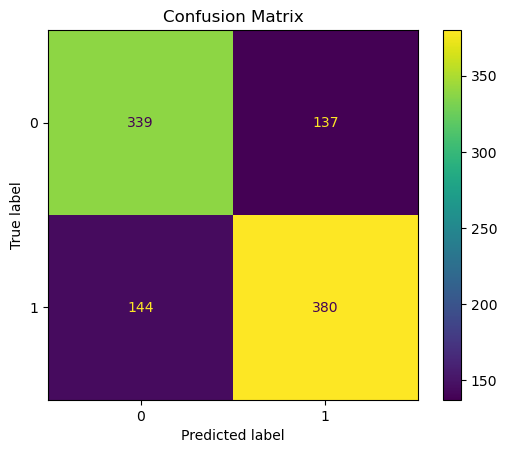

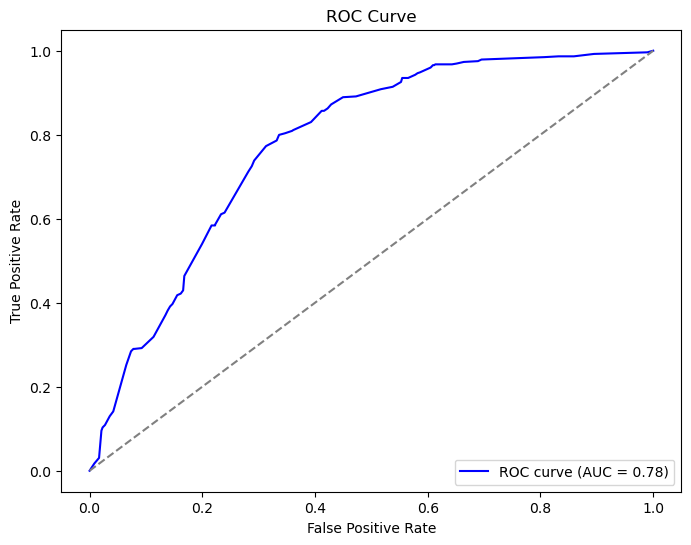

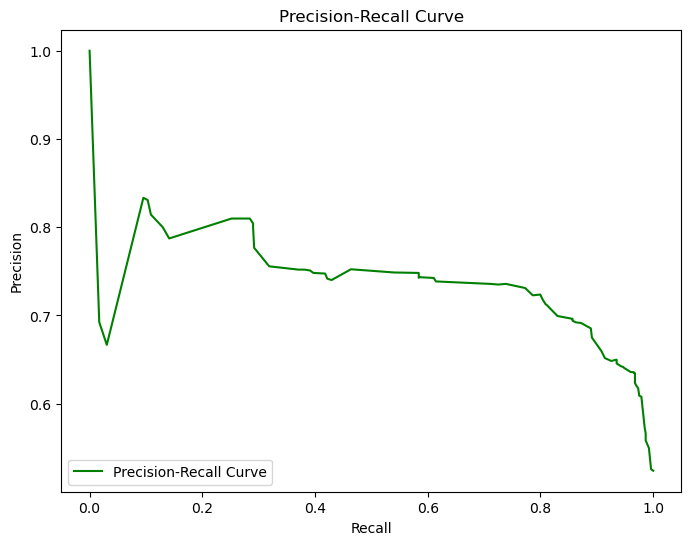

In [10]:
# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

#parameter grid
param_grid_dt = { #I could use more but these values seem to be the optimal ones
    'max_depth': [3, 5, 7, 10], #through testing these values seemed most realistic 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# ridSearchCV for hyperparameter tuning
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print(f"Best parameters for Decision Tree: {grid_dt.best_params_}")
y_pred_dt = grid_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_prob_dt = grid_dt.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_dt)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute the area under the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_dt)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

Best parameters for Random Forest: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 90}
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       476
           1       0.75      0.75      0.75       524

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



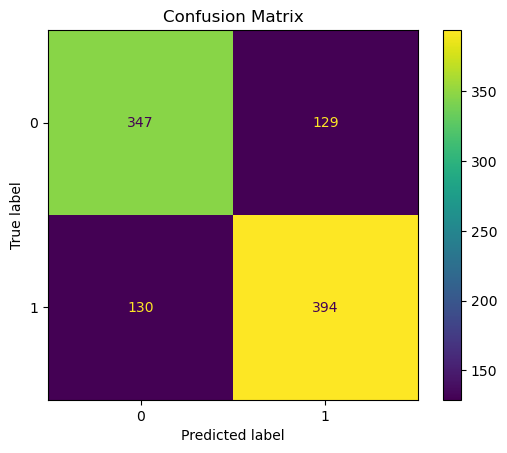

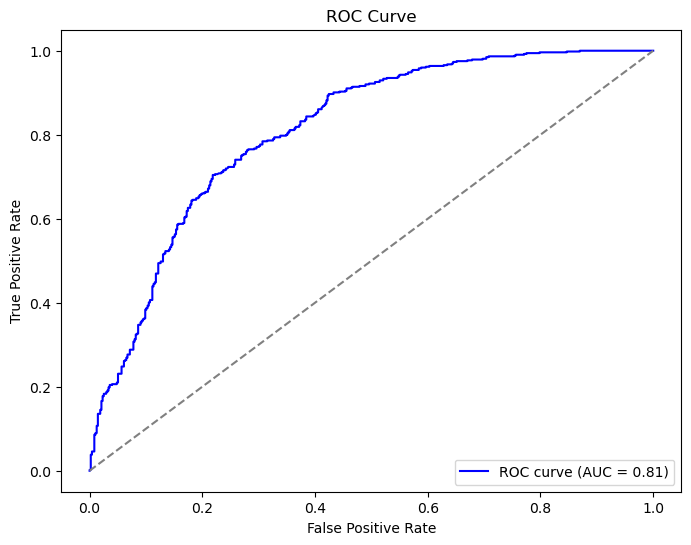

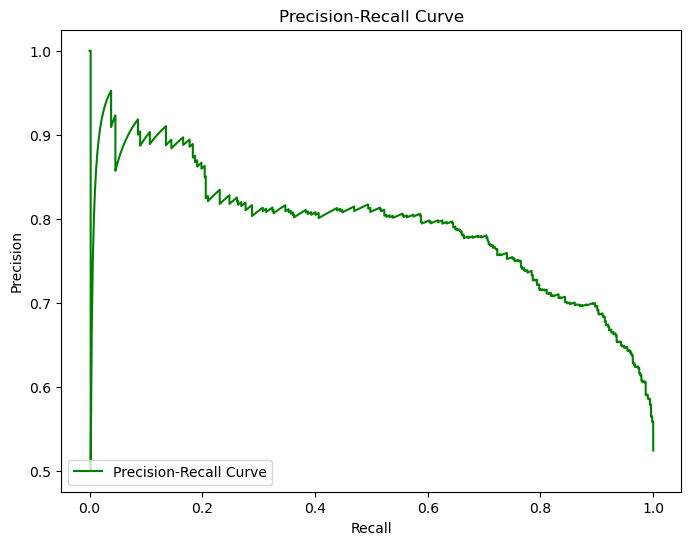

In [11]:
# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up parameter grid
param_grid_rf = { #I could use more but these values seem to be the optimal ones
    'n_estimators': [30, 60, 90], #using more can be computationally heavy and take too long
    'max_depth': [5,6,8, 10],
    'min_samples_split': [2, 5], #same case for all of these
    'min_samples_leaf': [1, 2,3,4] 
}

# Perform GridSearchCV for hyperparameter tuning
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")
y_pred_rf = grid_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_prob_rf = grid_rf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 120}
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       476
           1       0.75      0.75      0.75       524

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



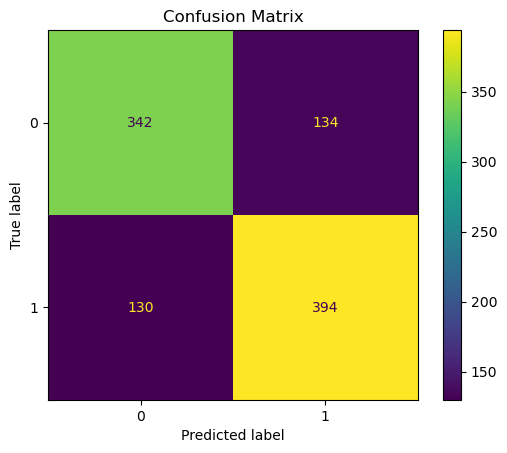

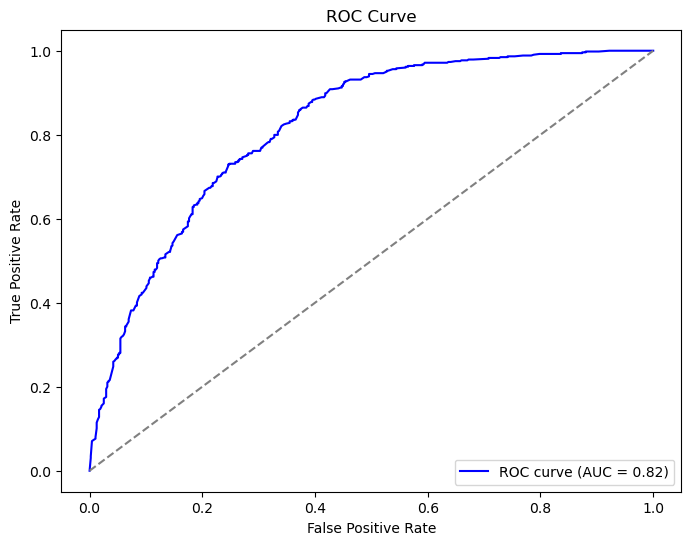

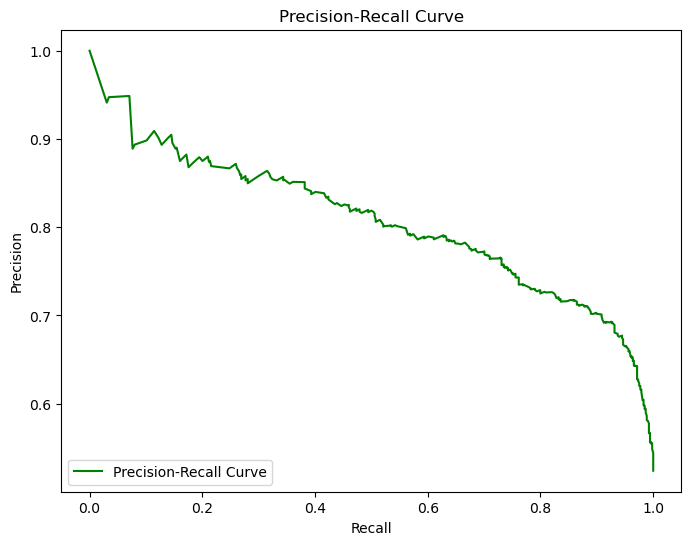

In [12]:
# Initialize AdaBoost model
ada = AdaBoostClassifier(algorithm = 'SAMME')

# parameter grid
param_grid_ada = { #I could use more but these values seem to be the optimal ones
    'n_estimators': [20,40,60,80,100,120,140], #difficult to try more iterations
    'learning_rate': [0.01, 0.1, 1] #small iterations seem to work well
}

# Perform GridSearchCV for hyperparameter tuning
grid_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='accuracy')
grid_ada.fit(X_train, y_train)
print(f"Best parameters for AdaBoost: {grid_ada.best_params_}")
y_pred_ada = grid_ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_ada)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_prob_ada = grid_ada.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_ada)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_ada)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 40, 'subsample': 0.6}
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       476
           1       0.75      0.77      0.76       524

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



C:\Users\Hasan\anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


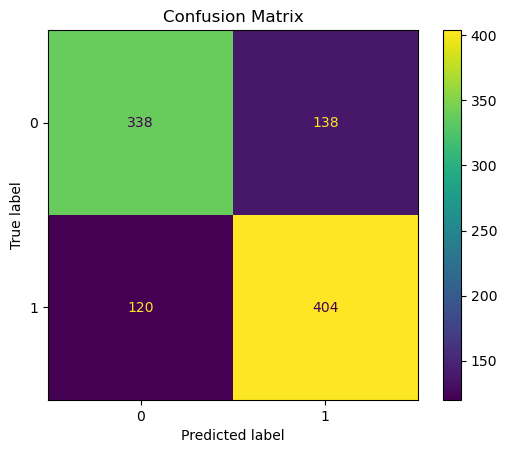

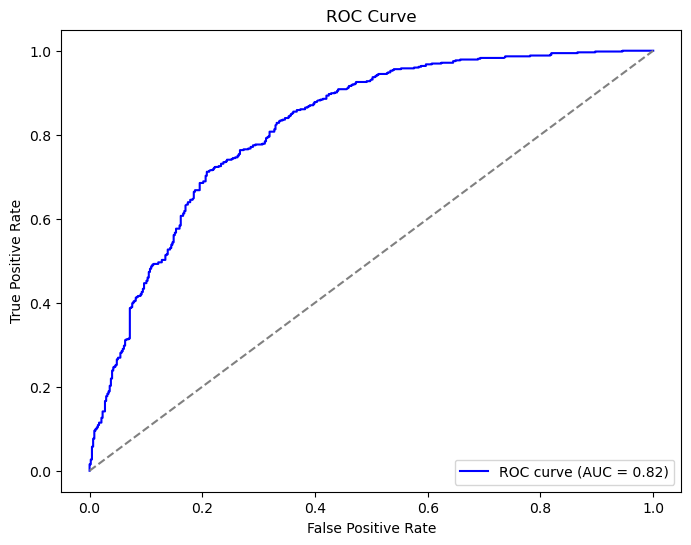

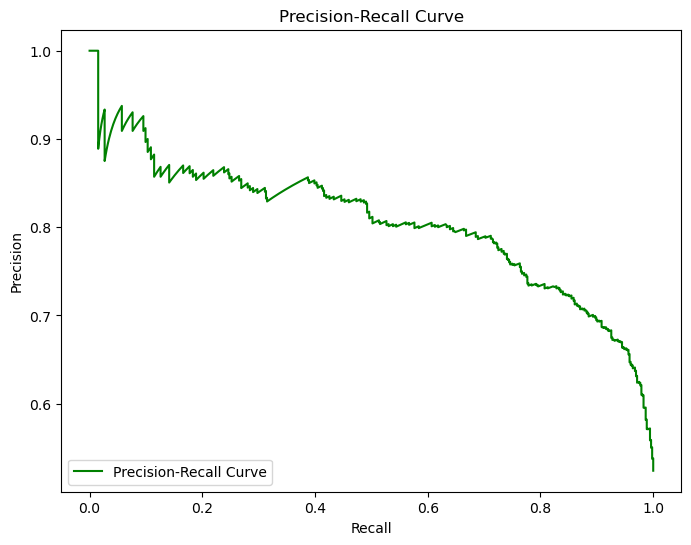

In [13]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# parameter grid
param_grid_xgb = { #I could use more but these values seem to be the optimal ones
    'n_estimators': [40,60,80,100,120], #same thing as before, computationally heavt to do more
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# Perform GridSearchCV for hyperparameter tuning
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

# Best parameters and model evaluation
print(f"Best parameters for XGBoost: {grid_xgb.best_params_}")
y_pred_xgb = grid_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_prob_xgb = grid_xgb.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

In [14]:
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_pred_ada)}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")

NameError: name 'accuracy_score' is not defined

# 2.3 Visualizing Trees

In [ ]:
from sklearn.tree import plot_tree

# Visualizing the best random decision tree model with optimized parameters
best_dt = grid_dt.best_estimator_ 

plt.figure(figsize=(100,80))
plot_tree(best_dt, 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True,
         fontsize = 18)
plt.title("Decision Tree", fontsize = 54)
plt.show()

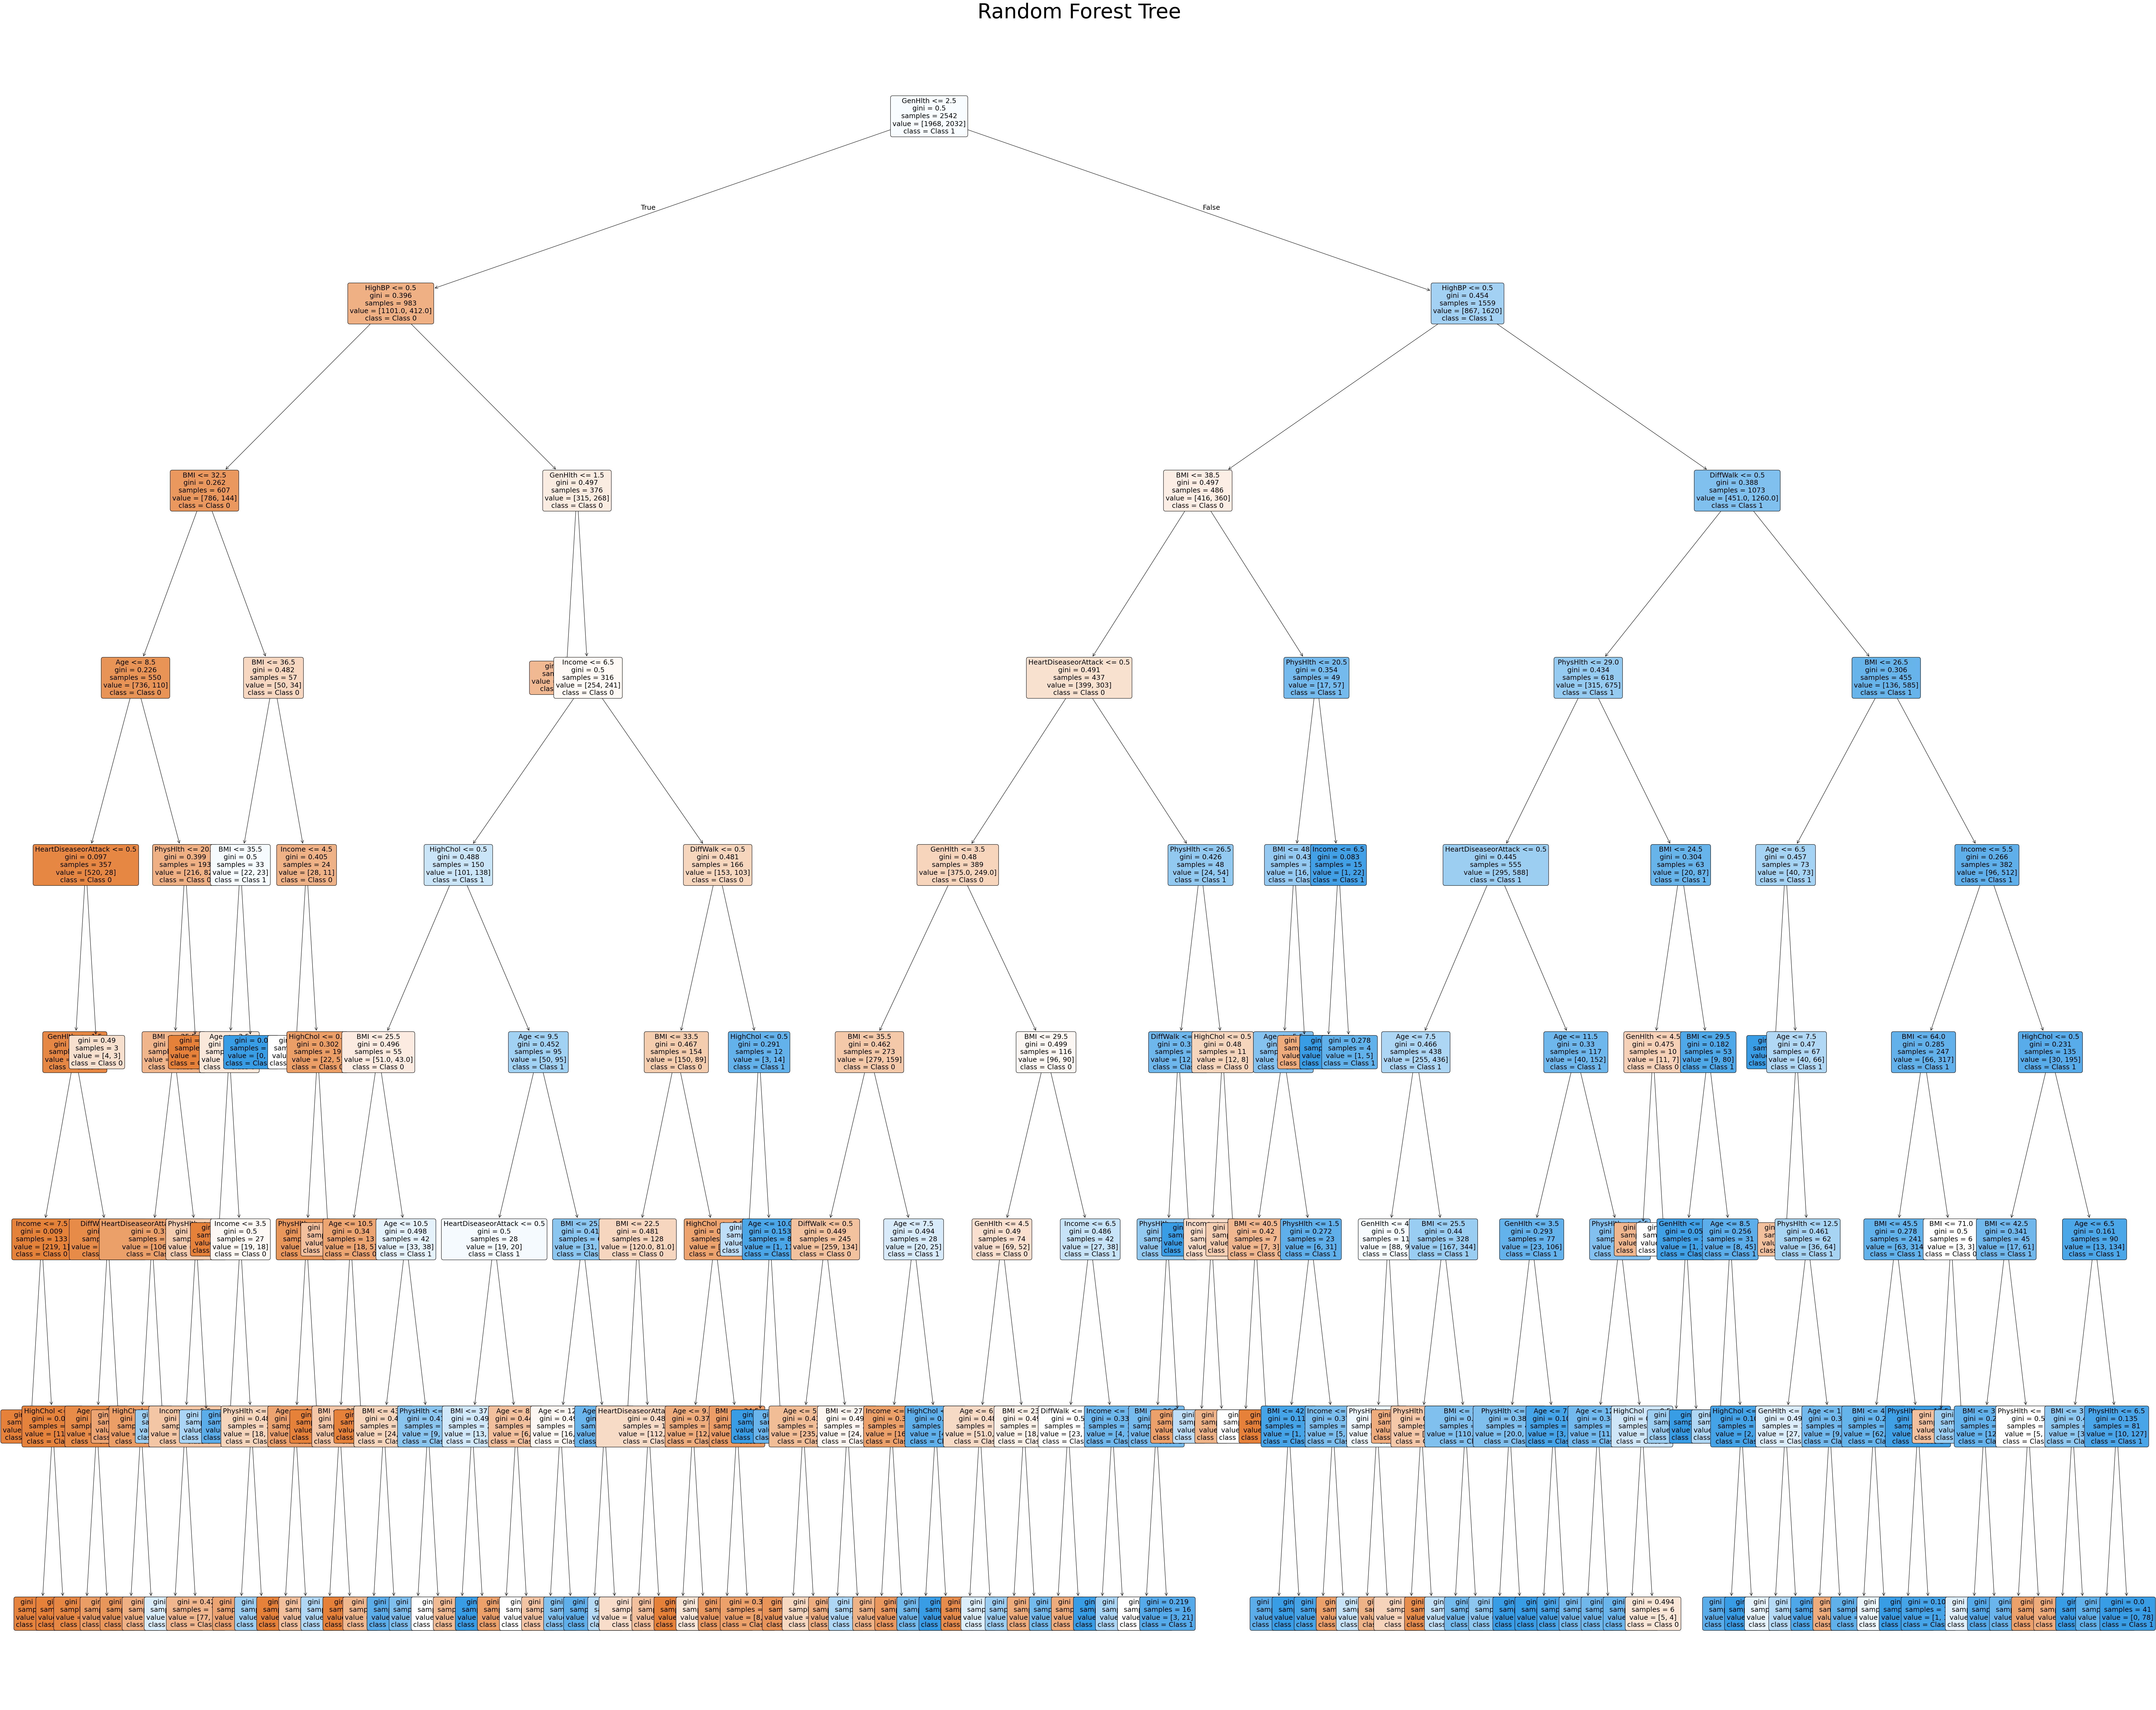

In [16]:
best_rf = grid_rf.best_estimator_

# Visualizing the best random forest model with optimized parameters
plt.figure(figsize=(100, 80))  
plot_tree(best_rf.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True,
          fontsize=18)  
plt.title("Random Forest Tree" ,fontsize = 54)  # Increase title font size
plt.show()

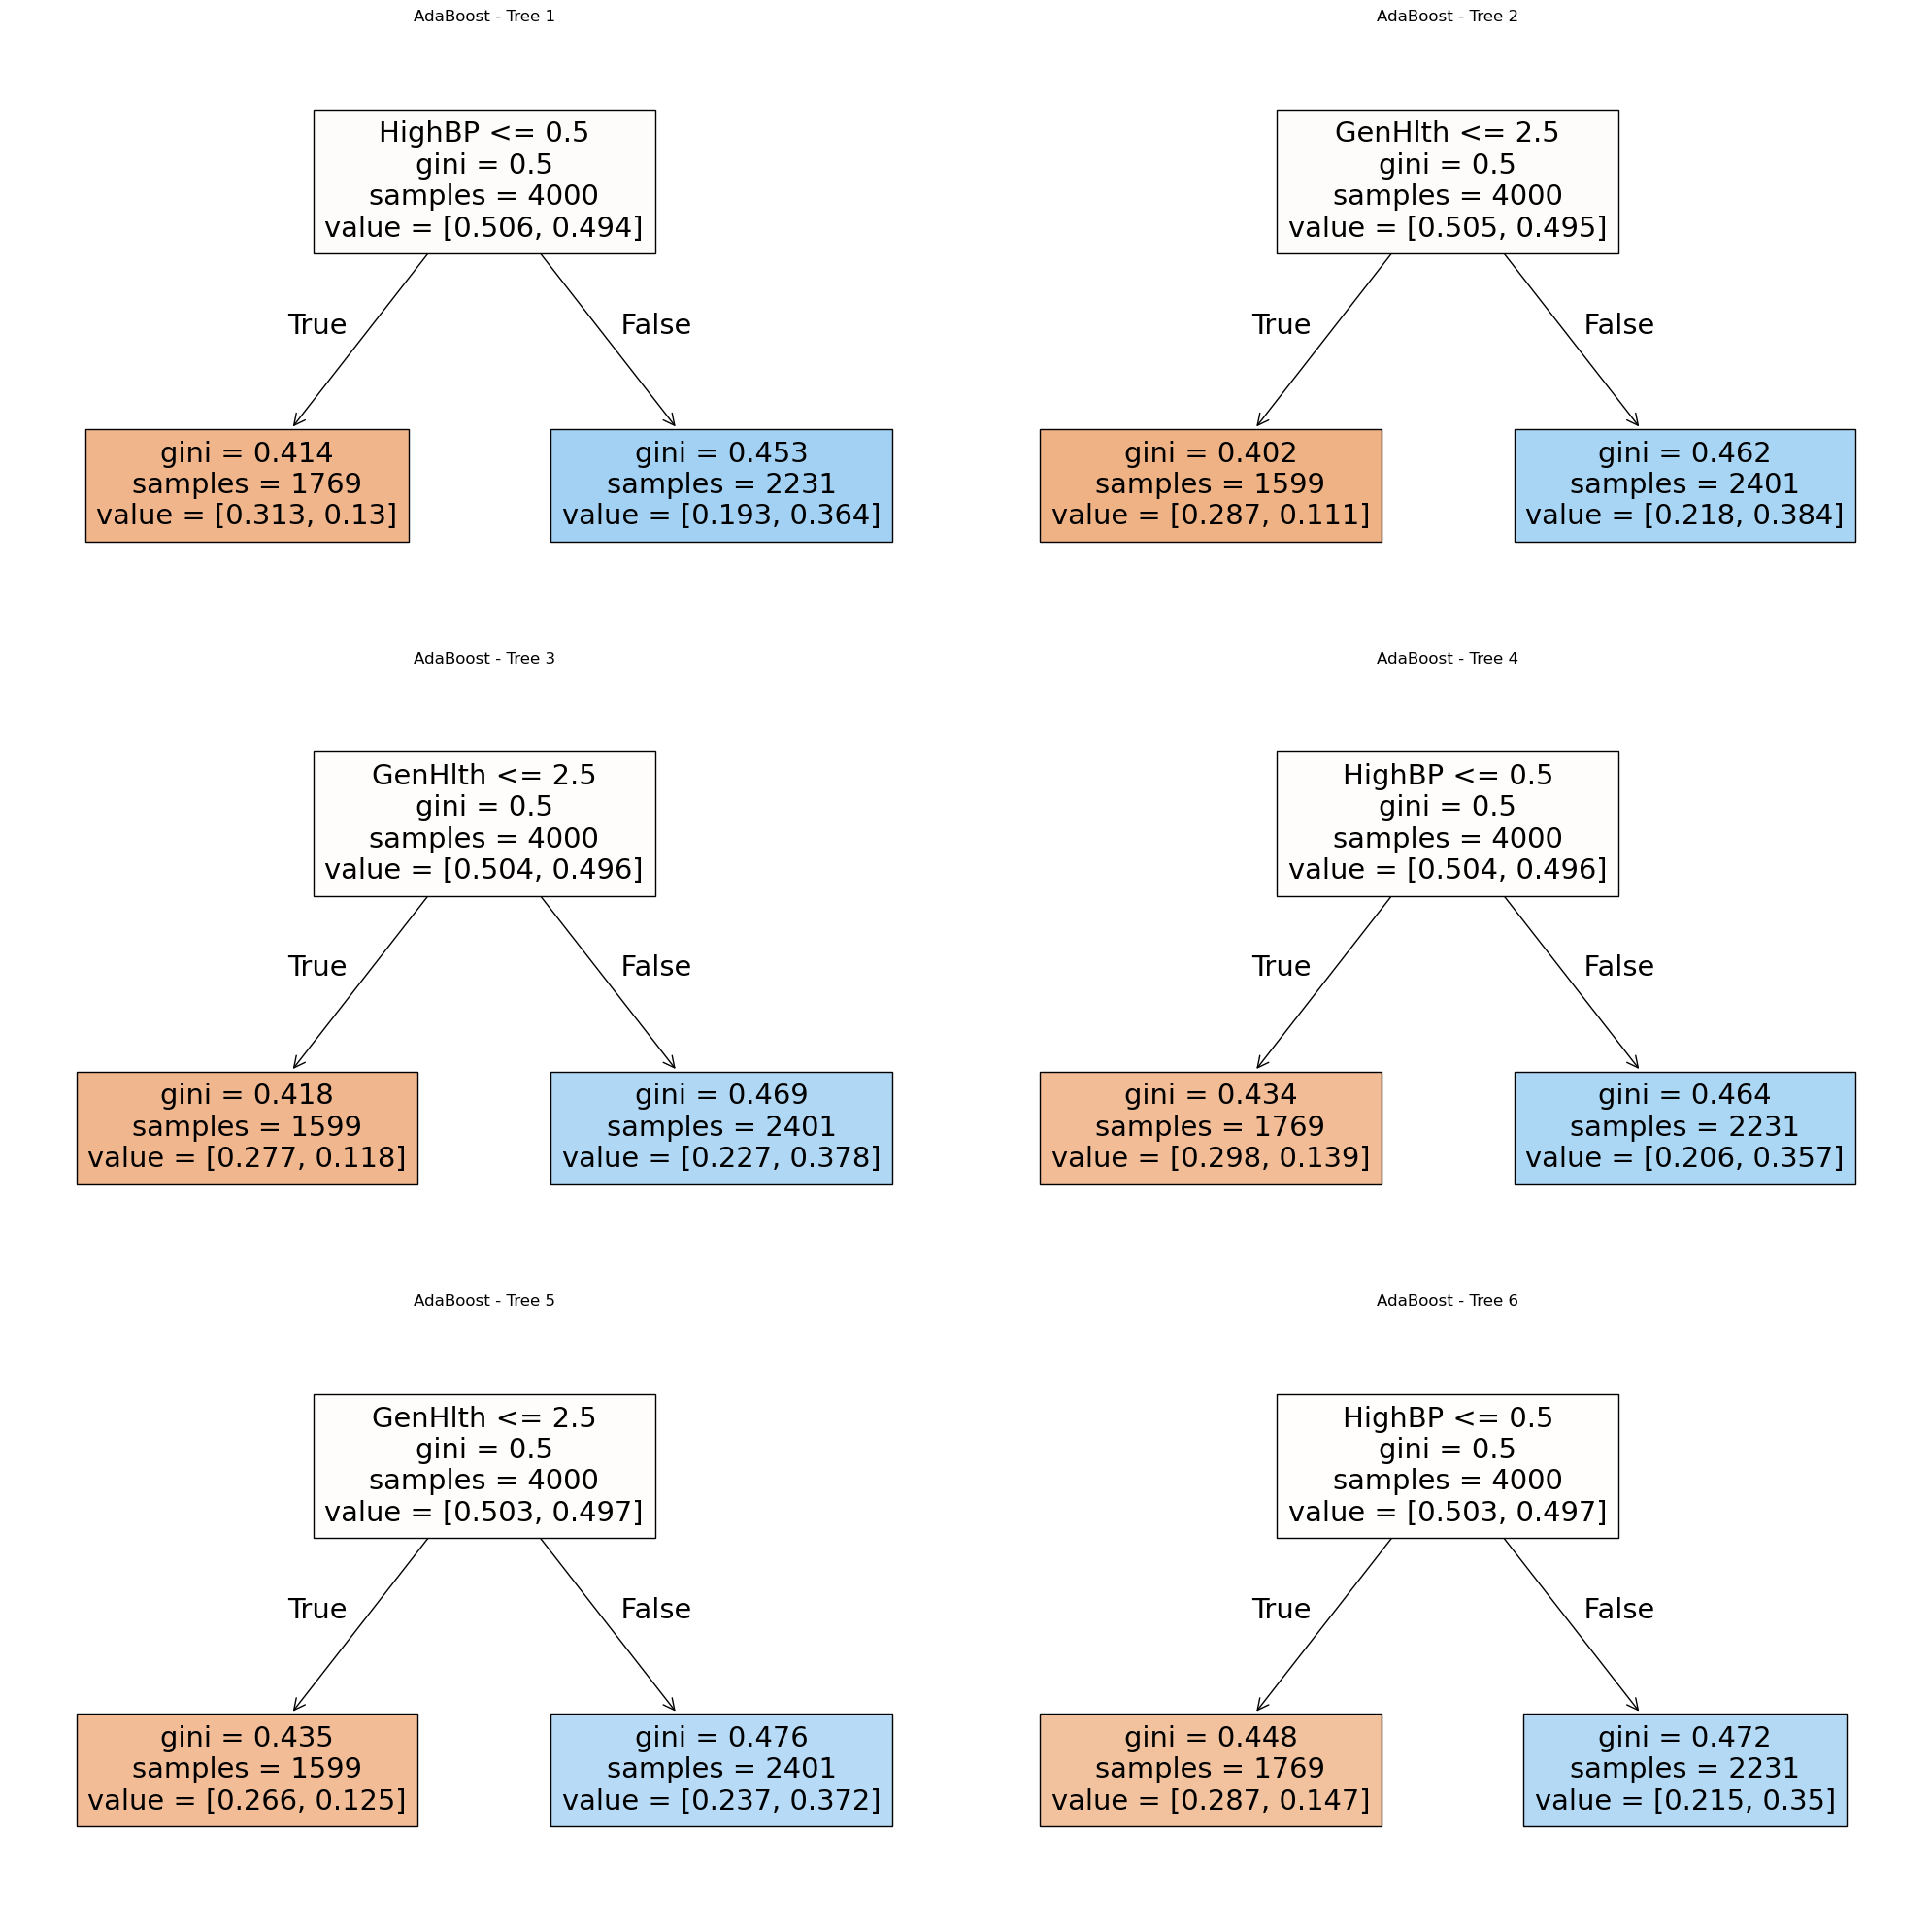

In [17]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get the best estimator for AdaBoost
best_ada_model = grid_ada.best_estimator_

# Number of trees in the AdaBoost model
n_trees = len(best_ada_model.estimators_)

# Plotting the best 
plt.figure(figsize=(20, 20))
for i in range(min(6, n_trees)):  #n trees is 6
    plt.subplot(3, 2, i + 1)
    plot_tree(best_ada_model.estimators_[i], feature_names=X.columns, filled=True)
    plt.title(f'AdaBoost - Tree {i + 1}')

plt.tight_layout()
plt.show()